Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# Set Cover problem

See: https://en.wikipedia.org/wiki/Set_cover_problem

In [5]:
from random import random, seed
from itertools import product, accumulate
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from icecream import ic

## Reproducible Initialization

If you want to get reproducible results, use `rng` (and restart the kernel); for non-reproducible ones, use `np.random`.

In [171]:
UNIVERSE_SIZE = 10
NUM_SETS = 5
DENSITY = 0.3

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

In [172]:
# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

## Helper Functions

In [196]:
def generate_data(universe_size, num_sets, density):
    SETS = np.random.random((num_sets, universe_size)) < density
    for s in range(universe_size):
        if not np.any(SETS[:, s]):
            SETS[np.random.randint(num_sets), s] = True
    COSTS = np.pow(SETS.sum(axis=1), 1.1)
    
    return SETS, COSTS

In [23]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    phenotype = np.logical_or.reduce(SETS[solution])     # at least each element covered by a set
    return np.all(phenotype)                             # all elements are covered


def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

## Have Fun!

In [9]:
# A dumb solution of "all" sets
def all_sets():
    solution = np.full(NUM_SETS, True)
    valid(solution), cost(solution)
    return solution

In [10]:
# A random solution with random 50% of the sets
rng_sol = rng.random(NUM_SETS) < .5
valid(rng_sol), cost(rng_sol)

(np.True_, np.float64(857.4538727499993))

In [202]:
def fitness(solution):
    return (valid(solution), -cost(solution))

### RM hill climbing with single mutation

In [18]:
def single_mutation(solution):
    pos = rng.integers(0, NUM_SETS)
    solution[pos] = not solution[pos]
    return solution

ic| sol_fitness: (np.True_, np.float64(-2016.4173929931355))


  0%|          | 0/1000 [00:00<?, ?it/s]

ic| sol_fitness: (np.True_, np.float64(-393.8684962607032))
ic| history.index(sol_fitness[1]): 148


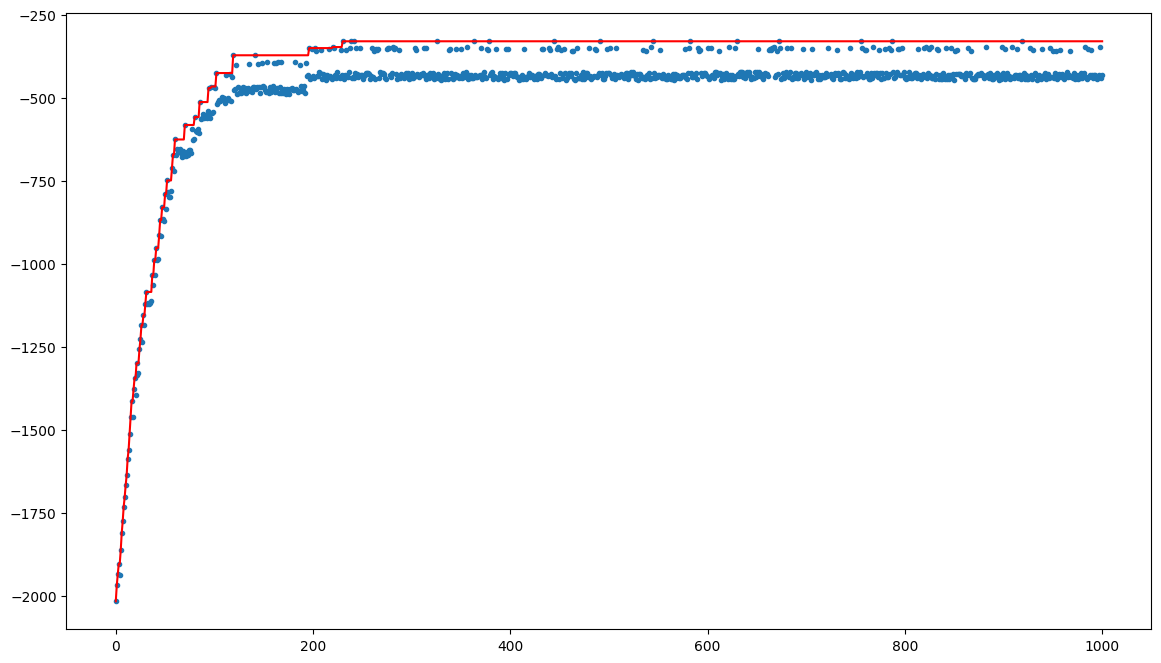

In [33]:
NUM_STEPS = 1000
history = []
solution = np.full(NUM_SETS, True)
sol_fitness = fitness(solution)

ic(sol_fitness)

history.append(sol_fitness[1])
for i in tqdm(range(NUM_STEPS)):
    current = single_mutation(solution.copy())
    curr_fitness = fitness(current)
    
    history.append(curr_fitness[1])
    if curr_fitness > sol_fitness:
        solution = current
        sol_fitness = curr_fitness

ic(sol_fitness)
ic(history.index(sol_fitness[1]))

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")

### RM hill climbing with multiple mutation

In [34]:
def multiple_mutation(solution):
    mask = rng.random(NUM_SETS) < 0.99
    new_solution = np.logical_xor(mask, solution)
    return new_solution

ic| sol_fitness: (np.True_, np.float64(-2016.4173929931355))


  0%|          | 0/1000 [00:00<?, ?it/s]

ic| sol_fitness: (np.True_, np.float64(-400.6433811691372))
ic| history.index(sol_fitness[1]): 179


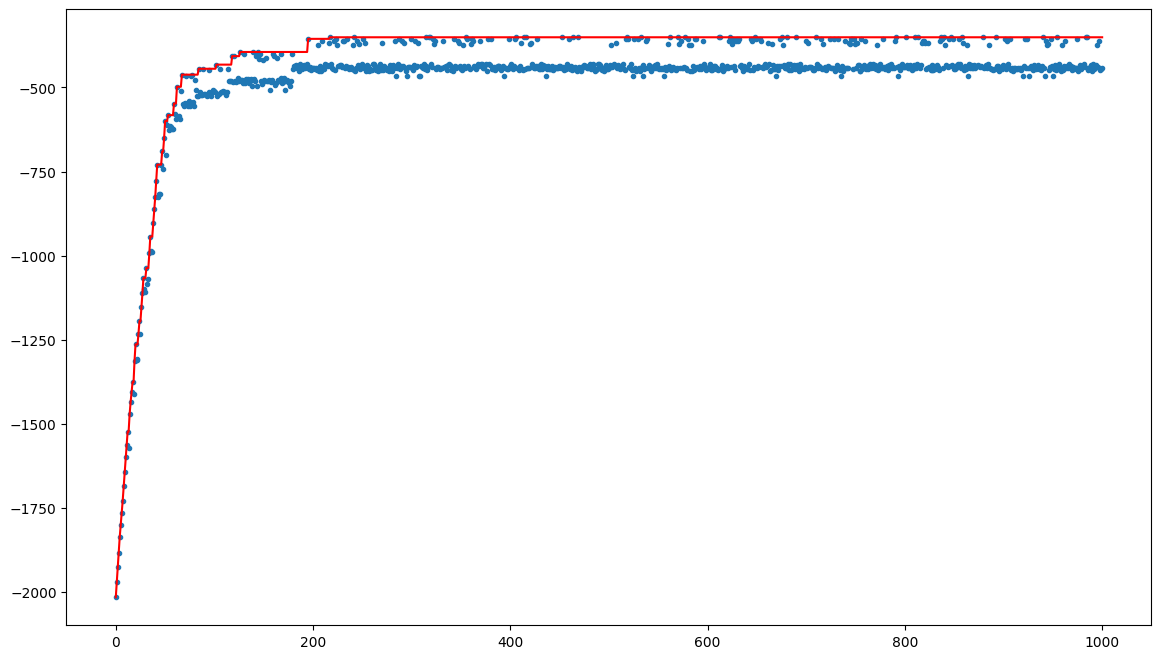

In [36]:
NUM_STEPS = 1000
history = []
solution = np.full(NUM_SETS, True)
sol_fitness = fitness(solution)

ic(sol_fitness)

history.append(sol_fitness[1])
for i in tqdm(range(NUM_STEPS)):
    current = single_mutation(solution.copy())
    curr_fitness = fitness(current)
    
    history.append(curr_fitness[1])
    if curr_fitness > sol_fitness:
        solution = current
        sol_fitness = curr_fitness

ic(sol_fitness)
ic(history.index(sol_fitness[1]))

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")

### Approccio greedy
Ad ogni iterazione, si prende l'insieme che copre il maggior numero di elementi non ancora coperti.
Si itera fino a coprire tutti gli elementi nell'universo

In [208]:
class Set:
    def __init__(self, elements: np.ndarray) -> None:
        self.elements = set(elements)
        
    def decrease(self, elem: int) -> bool:
        if elem in self.elements:
            self.elements.remove(elem)
            return True
        return False
    
    def size(self) -> int:
        return len(self.elements)
        
    def __repr__(self) -> str:
        return ",".join([str(elem) for elem in self.elements])
    
    def __str__(self) -> str:
        return self.__repr__()
        
    def __lt__(self, other) -> bool:
        return len(self.elements) < len(other.elements)
    

def greedy_solve(set_matrix) -> np.ndarray:
    
    sets = [Set(np.where(row == True)[0]) for row in set_matrix]
    solution = np.full(NUM_SETS, False)
    covered = 0

    while covered < UNIVERSE_SIZE:
        largest_index = np.argmax(sets)
        largest = sets[largest_index]
        solution[largest_index] = True
        sets[largest_index] = Set([])
        for elem in largest.elements:
            _ = [set.decrease(elem) for set in sets]
        covered += largest.size()
        print(covered, end=" ")
        
    #ic(solution)
    
    return solution

## Greedy solver
It has memory issues for instance 4

In [209]:
universe_sizes = [100, 1000, 10_000, 100_000, 100_000, 100_000]
num_sets_sizes = [10, 100, 1000, 10_000, 10_000, 10_000]
densities = [.2, .2, .2, .1, .2, .3]

for (UNIVERSE_SIZE, NUM_SETS, DENSITY) in zip(universe_sizes, num_sets_sizes, densities):
    
    SETS, COSTS = generate_data(UNIVERSE_SIZE, NUM_SETS, DENSITY)

    solution = greedy_solve(SETS)

    fitness_sol = fitness(solution)
    ic(fitness_sol)

ic| fitness_sol: (np.True_, np.float64(-271.59775950373665))


26 44 59 69 78 84 89 94 97 100 233 412 546 654 738 803 

ic| fitness_sol: (np.True_, np.float64(-5833.343734573702))


853 890 920 943 961 974 984 991 996 999 1000 2114 3800 5148 6214 7073 7740 8267 8668 8978 9221 9407 9559 9673 9763 9829 9879 9917 9944 

ic| fitness_sol: (np.True_, np.float64(-100746.61176676706))


9964 9980 9990 9997 10000 

MemoryError: 